In [1]:
import sys
from pathlib import Path

# Get the folder where this notebook is running
notebook_path = Path().resolve()

# Assume 'src' is at the project root, one level up from the notebook folder
project_root = notebook_path.parent

# Construct the full path to src
src_path = project_root / "src"

# Add src to sys.path if not already there
if str(src_path) not in sys.path:
    sys.path.insert(1, str(src_path))

print(f"Added {src_path} to sys.path")

Added /home/rodolfo/Documents/Rodolfo/Python_Projects/projetos_sem_espacos/churn-powerco/powerco-churn/src to sys.path


In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import matplotlib.gridspec as gridspec
import numpy as np
from scipy.stats import linregress
import matplotlib.ticker as mtick
from sklearn.model_selection import train_test_split
from sklearn import set_config
from functools import reduce
import warnings

from sklearn.experimental import enable_iterative_imputer  
from sklearn.impute import IterativeImputer
from sklearn.ensemble import HistGradientBoostingRegressor

from powerco_churn.EDA.basic_data_wrangling import basic_wrangling
from powerco_churn.EDA.univariate_statistics import univariate_statistics, plot_histograms_countplots
from powerco_churn.EDA.bivariate_statistics import bivariate_stats
from powerco_churn.EDA.visualizing_bivariate_statistics import generate_bar_plot
from powerco_churn.EDA.outliers import calculate_outlier_threshold
from powerco_churn.EDA.skewness import correct_skew
from powerco_churn.EDA.date_utils import parse_and_format_dates

# Configuration

In [3]:
# plot will similiar to ggplot
plt.style.use('ggplot')

random_seed = 42

#set output of skllearn to be a pandas dataframe
set_config(transform_output = "default")


# Load Data

Two dataframes:

- client_data containing information about the clients (train and test)
- price_data containing the prices of power and energy during 2015

In [4]:
#train data
client_data_train = pd.read_csv('../data/raw/train/train_client_data.csv')

#test data
client_data_test  = pd.read_csv('../data/raw/test/test_client_data.csv')


In [5]:
#train data
price_data_train = pd.read_csv('../data/raw/train/train_price_data.csv')

#test data    
price_data_test  = pd.read_csv('../data/raw/test/test_price_data.csv')

#  Feature Engineering

## Client Data

### Date Features

- There is already a feature that that indicates how long the client has been with the energy company;
- Creating a new feature that indicates the length of the active contract;
- How long will it take for the contract to end?
- How long since the last modification?

The date features will be used to create three new features and then will be removed

In [6]:
date_features = ['date_activ', 'date_end', 'date_modif_prod', 'date_renewal']

In [7]:
for feature in date_features:
    client_data_train[feature] = client_data_train[feature].apply(parse_and_format_dates)
    client_data_test[feature] = client_data_test[feature].apply(parse_and_format_dates)

In [8]:
client_data_train['contract_length'] = (pd.to_datetime(client_data_train['date_end'])
                                    - pd.to_datetime(client_data_train['date_activ'])).dt.days

client_data_test['contract_length'] = (pd.to_datetime(client_data_test['date_end'])
                                    - pd.to_datetime(client_data_test['date_activ'])).dt.days


# a random date selected to be more recent than the last date in the dataset
reference_date = pd.to_datetime('2020-01-01')

client_data_train['days_until_end'] = (reference_date - pd.to_datetime(client_data_train['date_end'])).dt.days
client_data_train['days_since_modification'] = (reference_date - pd.to_datetime(client_data_train['date_modif_prod'])).dt.days

client_data_test['days_until_end'] = (reference_date - pd.to_datetime(client_data_test['date_end'])).dt.days
client_data_test['days_since_modification'] = (reference_date - pd.to_datetime(client_data_test['date_modif_prod'])).dt.days

In [9]:
client_data_train.drop(columns = date_features, inplace = True)
client_data_test.drop(columns = date_features, inplace = True)

## Price Data

Creating new features from the time series of the prices in the price_data dataframe. These new features are aggregations of the prices charged the clients during 2015

- mean prices;
- last price;
- the difference between the first and the last prices;
- the slope of the linear regression attached to the prices;
- standard deviation of the prices;

In [10]:
numeric_columns_price = price_data_train.select_dtypes(include='number').columns.to_list()
numeric_columns_price

['price_off_peak_var',
 'price_peak_var',
 'price_mid_peak_var',
 'price_off_peak_fix',
 'price_peak_fix',
 'price_mid_peak_fix']

### Mean Prices

Mean prices for each client

In [11]:
mean_price_train = price_data_train.groupby('id')[numeric_columns_price].mean().reset_index()
mean_price_test  = price_data_test.groupby('id')[numeric_columns_price].mean().reset_index()


mean_price_columns = ['id'] + [f'mean_{col}' for col in mean_price_train.columns[1:]]
mean_price_train.columns = mean_price_columns
mean_price_test.columns = mean_price_columns



Creating four new features:

- Mean of the energy price in the three periods (off-peak, mid-peak and peak);
- Mean of the potency price in the three periods;
- Difference between the energy prices in the peak period and off-peak periods;
- Difference between the potency price in the peak and off-peak periods.


In [12]:
def create_new_energy_potency_mean_features(df: pd.DataFrame) -> pd.DataFrame:
    """
    Create new features based on energy and potency prices.

    Parameters
    ----------
    df : pd.DataFrame
        The input DataFrame.

    Returns
    -------
    pd.DataFrame
        DataFrame with new features.
    """

    energy_features  = [feature for feature in df.columns if 'var' in feature]
    potency_features = [feature for feature in df.columns if 'fix' in feature]

    df['mean_energy_price']  = df[energy_features].mean(axis = 1)
    df['mean_potency_price'] = df[potency_features].mean(axis = 1)

    df['energy_peak_minus_offpeak']  = df['mean_price_peak_var'] - df['mean_price_off_peak_var']
    df['potency_peak_minus_offpeak'] = df['mean_price_peak_fix'] - df['mean_price_off_peak_fix']

    return df



In [13]:
mean_price_train  = create_new_energy_potency_mean_features(mean_price_train)
mean_price_test   = create_new_energy_potency_mean_features(mean_price_test)

In [14]:
mean_price_train.head()

,id,mean_price_off_peak_var,mean_price_peak_var,mean_price_mid_peak_var,mean_price_off_peak_fix,mean_price_peak_fix,mean_price_mid_peak_fix,mean_energy_price,mean_potency_price,energy_peak_minus_offpeak,potency_peak_minus_offpeak
0,0002203ffbb812588b632b9e628cc38d,0.124338,0.103794,0.07316,40.701732,24.421038,16.280694,0.100431,27.134488,-0.020545,-16.280694
1,0010bcc39e42b3c2131ed2ce55246e3c,0.181558,0.000000,0.00000,45.319710,0.000000,0.000000,0.060519,15.106570,-0.181558,-45.319710
2,00114d74e963e47177db89bc70108537,0.147926,0.000000,0.00000,44.266930,0.000000,0.000000,0.049309,14.755643,-0.147926,-44.266930
3,00184e957277eeef733a7b563fdabd06,0.147637,0.000000,0.00000,44.266930,0.000000,0.000000,0.049212,14.755643,-0.147637,-44.266930
4,001987ed9dbdab4efa274a9c7233e1f4,0.122756,0.102290,0.07303,40.647427,24.388455,16.258972,0.099359,27.098285,-0.020465,-16.258972


### Last Price

In [15]:
def create_last_price_features(df: pd.DataFrame) -> pd.DataFrame:
    """
    Create new features based on the last values of the time series.

    Parameters
    ----------
    df : pd.DataFrame
        The input DataFrame.

    Returns
    -------
    pd.DataFrame
        DataFrame with new features.
    """    

    last_price = df.loc[df.groupby('id')['price_date'].idxmax()]
    last_price = last_price.reset_index(drop=True)
    last_price = last_price.drop(columns = ['price_date'])

    last_price.columns = ['id'] + [f'last_{col}' for col in last_price.columns[1:]] 

    return last_price

In [16]:
last_price_train = create_last_price_features(price_data_train)
last_price_test  = create_last_price_features(price_data_test)

### Difference between first and last prices

In [17]:
def calculate_difference_last_first_prices(df: pd.DataFrame) -> pd.DataFrame:
    """
    Create  new features that represents the difference between the last and first prices.

    Parameters
    ----------
    df : pd.DataFrame
        The input DataFrame.

    Returns
    -------
    pd.DataFrame
        DataFrame with new feature.
    """

    last = df.loc[df.groupby('id')['price_date'].idxmax()].set_index('id', drop = True)
    last = last.drop(columns = ['price_date'])
    first = df.loc[df.groupby('id')['price_date'].idxmin()].set_index('id', drop = True)
    first = first.drop(columns = ['price_date'])

    difference = last - first


    return difference

In [18]:
difference_last_first_prices_train  = calculate_difference_last_first_prices(price_data_train)
difference_last_first_prices_test  = calculate_difference_last_first_prices(price_data_test)

### Slope of the linear regression

In [19]:
def calculate_slopes_linear_regression(df: pd.DataFrame) -> pd.DataFrame:
    """
    Create  new features that represents the slope of the lienar regressin
    adjusted to the prices

    Parameters
    ----------
    df : pd.DataFrame
        The input DataFrame.

    Returns
    -------
    pd.DataFrame
        DataFrame with new feature.
    """
    numeric_columns_price = [feature for feature in df.columns if pd.api.types.is_numeric_dtype(df[feature])]

    agg_dict = {
        f'{col}_slope' : (col, lambda x: linregress(np.arange(len(x)), x).slope)
        for col in numeric_columns_price
    }

    slopes_regression = df.groupby('id').agg(**agg_dict)
    slopes_regression = slopes_regression.reset_index()
    slopes_regression.head()

    return slopes_regression

In [20]:
slope_prices_train = calculate_slopes_linear_regression(price_data_train)
slopes_prices_test = calculate_slopes_linear_regression(price_data_test)

### Standard Deviation

In [21]:
std_price_train = price_data_train.groupby('id')[numeric_columns_price].std()
std_price_test  = price_data_test.groupby('id')[numeric_columns_price].std()


std_price_train = std_price_train.reset_index()
std_price_test  = std_price_test.reset_index()

std_price_train.columns = ['id'] + [f'std_{col}' for col in std_price_train.columns[1:]]
std_price_test.columns = ['id'] + [f'std_{col}' for col in std_price_test.columns[1:]]  


### Concatenating All Dataframes

In [22]:
df_list_train = [client_data_train, mean_price_train, last_price_train, difference_last_first_prices_train, slope_prices_train, std_price_train]
df_list_test  = [client_data_test, mean_price_test, last_price_test, difference_last_first_prices_test, slopes_prices_test, std_price_test]

In [23]:
client_price_train = reduce(lambda left, right: pd.merge(left, right, on='id', how='inner'), df_list_train)
client_price_test  = reduce(lambda left, right: pd.merge(left, right, on='id', how='inner'), df_list_test)


In [24]:
y_train = client_data_train['churn']
x_train = client_price_train.drop(columns = ['churn'])

y_test = client_data_test['churn']
x_test = client_price_test.drop(columns = ['churn'])

del(client_data_train, client_data_test, client_price_train, client_price_test)

## Data Preprocessing

In [25]:
uni_stats_client_data = univariate_statistics(x_train)
uni_stats_client_data


,type,count,missing,unique,mode,min_value,q_1,median,q_3,max_value,mean,std,skew,kurtosis
feature,,,,,,,,,,,,,,
id,object,11684,0,11684,0002203ffbb812588b632b9e628cc38d,-,-,-,-,-,-,-,-,-
channel_sales,object,11684,0,8,foosdfpfkusacimwkcsosbicdxkicaua,-,-,-,-,-,-,-,-,-
cons_12m,int64,11684,0,9219,0,0,5609.0,14139.0,41121.5,6207104,159429.231,571752.758,6.029,43.573
cons_gas_12m,int64,11684,0,1716,0,0,0.0,0.0,0.0,4154590,27843.623,163052.758,10.009,139.96
cons_last_month,int64,11684,0,4225,0,0,0.0,813.0,3435.0,771203,16149.339,64088.349,6.378,47.921
forecast_cons_12m,float64,11684,0,11222,0.0,0.0,488.34,1099.43,2404.1825,82902.83,1868.707,2419.608,7.775,169.078
forecast_cons_year,int64,11684,0,3739,0,0,0.0,321.0,1769.0,175375,1426.479,3414.982,17.364,665.216
forecast_discount_energy,float64,11684,0,12,0.0,0.0,0.0,0.0,0.0,30.0,0.957,5.075,5.179,25.116
forecast_meter_rent_12m,float64,11684,0,3145,0.0,0.0,16.18,18.725,131.02,599.31,63.06,65.964,1.438,3.802


### Missing Values

In [26]:
#Trere are not missing values
x_train.isna().sum()

id                                0
channel_sales                     0
cons_12m                          0
cons_gas_12m                      0
cons_last_month                   0
forecast_cons_12m                 0
forecast_cons_year                0
forecast_discount_energy          0
forecast_meter_rent_12m           0
forecast_price_energy_off_peak    0
forecast_price_energy_peak        0
forecast_price_pow_off_peak       0
has_gas                           0
imp_cons                          0
margin_gross_pow_ele              0
margin_net_pow_ele                0
nb_prod_act                       0
net_margin                        0
num_years_antig                   0
origin_up                         0
pow_max                           0
contract_length                   0
days_until_end                    0
days_since_modification           0
mean_price_off_peak_var           0
mean_price_peak_var               0
mean_price_mid_peak_var           0
mean_price_off_peak_fix     

### Basic Wrangling

In [27]:
x_train = basic_wrangling(x_train)
x_test  = basic_wrangling(x_test)

2025-06-03 15:24:25,203 - INFO - Starting data wrangling...
2025-06-03 15:24:25,210 - INFO - Feature id removed. The proportion of unique values in the feature of type object is 100.00%
2025-06-03 15:24:25,233 - INFO - Starting data wrangling...
2025-06-03 15:24:25,235 - INFO - Feature id removed. The proportion of unique values in the feature of type object is 100.00%


### Outliers

In [28]:
feature_outliers = {}

for feature in x_train.columns:
    if pd.api.types.is_numeric_dtype(x_train[feature]):
        min_thresh, max_thresh = calculate_outlier_threshold(x_train, feature)
        feature_outliers[feature] = {'max_thresh': max_thresh, 'min_thresh': min_thresh}
        


In [29]:
def replace_outliers(df: pd.DataFrame, feature_thresholds: dict, verbose = False) -> pd.DataFrame:
    """
    Replace outliers in a dataframe based on a dictionary of feature thresholds.

    Args:
        df (pd.DataFrame): a pandas DataFrame
        feature_thresholds (dict): a dictionary of feature thresholds.
            For each feature, the dictionary contains the maximum and minimum thresholds for outlier detection.
        verbose (bool, optional): Whether to print verbose information. Defaults to False.

    Returns:
        pd.DataFrame: _
    """
    df = df.copy()
    for feature in feature_thresholds:
        if verbose:
            num_outliers = (df[feature] > feature_thresholds[feature]['max_thresh']).sum()
            num_outliers += (df[feature] < feature_thresholds[feature]['min_thresh']).sum()
            print(f'Number of outliers in {feature}: {num_outliers}')  
        df[feature] = df[feature].mask(df[feature] > feature_thresholds[feature]['max_thresh'], 
                                        feature_thresholds[feature]['max_thresh'])
        df[feature] = df[feature].mask(df[feature] < feature_thresholds[feature]['min_thresh'], 
                                        feature_thresholds[feature]['min_thresh'])
        
    return df



In [30]:
x_train_cleaned = replace_outliers(x_train, feature_outliers, verbose = True)
x_test_cleaned  = replace_outliers(x_test, feature_outliers, verbose = False)

Number of outliers in cons_12m: 1646
Number of outliers in cons_gas_12m: 2095
Number of outliers in cons_last_month: 1641
Number of outliers in forecast_cons_12m: 840
Number of outliers in forecast_cons_year: 1034
Number of outliers in forecast_discount_energy: 407
Number of outliers in forecast_meter_rent_12m: 124
Number of outliers in forecast_price_energy_off_peak: 179
Number of outliers in forecast_price_energy_peak: 0
Number of outliers in forecast_price_pow_off_peak: 289
Number of outliers in imp_cons: 974
Number of outliers in margin_gross_pow_ele: 532
Number of outliers in margin_net_pow_ele: 532
Number of outliers in nb_prod_act: 2546
Number of outliers in net_margin: 810
Number of outliers in num_years_antig: 309
Number of outliers in pow_max: 1243
Number of outliers in contract_length: 296
Number of outliers in days_until_end: 0
Number of outliers in days_since_modification: 112
Number of outliers in mean_price_off_peak_var: 167
Number of outliers in mean_price_peak_var: 0
N

### Skewness

In [31]:
univariate_stats_train_data = univariate_statistics(x_train_cleaned)
univariate_stats_train_data['skew'] = univariate_stats_train_data['skew'].mask(univariate_stats_train_data['skew'] == '-', np.nan)
univariate_stats_train_data.sort_values(by = 'skew', ascending = False)

,type,count,missing,unique,mode,min_value,q_1,median,q_3,max_value,mean,std,skew,kurtosis
feature,,,,,,,,,,,,,,
price_peak_var,float64,11684,0,977,0.0,-0.034,-0.002904,0.0,0.0,0.03209,-0.001,0.006,2.134,23.732
price_mid_peak_fix,float64,11684,0,10,0.0,-0.098,0.0,0.0,0.065166,0.162916,0.021,0.04,1.65,3.72
price_peak_fix,float64,11684,0,12,0.0,-0.147,0.0,0.0,0.097749,0.244373,0.031,0.06,1.615,3.507
std_price_mid_peak_fix,float64,11684,0,96,0.0,0.0,0.0,0.0,0.025366,0.063415,0.011,0.018,1.579,1.483
std_price_peak_fix,float64,11684,0,99,0.0,0.0,0.0,0.0,0.038049,0.095124,0.016,0.028,1.553,1.379
std_price_mid_peak_var,float64,11684,0,1188,0.0,0.0,0.0,0.0,0.000845,0.002113,0.0,0.001,1.27,0.175
forecast_cons_year,float64,11684,0,2788,0.0,0.0,0.0,321.0,1769.0,4422.5,1091.727,1475.321,1.239,0.154
imp_cons,float64,11684,0,5370,0.0,0.0,0.0,37.795,195.995,489.9875,121.022,161.578,1.23,0.174
cons_last_month,float64,11684,0,3387,0.0,0.0,0.0,813.0,3435.0,8587.5,2309.222,3040.068,1.205,-0.061


In [32]:
skewed_features = univariate_stats_train_data.loc[univariate_stats_train_data['skew'] > 0.5].index
skewed_features

Index(['cons_12m', 'cons_last_month', 'forecast_cons_12m',
       'forecast_cons_year', 'forecast_meter_rent_12m', 'imp_cons',
       'margin_gross_pow_ele', 'margin_net_pow_ele', 'net_margin',
       'num_years_antig', 'pow_max', 'contract_length',
       'days_since_modification', 'mean_price_peak_fix',
       'mean_price_mid_peak_fix', 'last_price_mid_peak_var',
       'last_price_peak_fix', 'last_price_mid_peak_fix', 'price_peak_var',
       'price_mid_peak_var', 'price_off_peak_fix', 'price_peak_fix',
       'price_mid_peak_fix', 'price_peak_var_slope',
       'price_mid_peak_var_slope', 'price_off_peak_fix_slope',
       'price_peak_fix_slope', 'price_mid_peak_fix_slope',
       'std_price_off_peak_var', 'std_price_peak_var',
       'std_price_mid_peak_var', 'std_price_off_peak_fix',
       'std_price_peak_fix', 'std_price_mid_peak_fix'],
      dtype='object', name='feature')

In [34]:
x_train_cleaned['cons_12m'].skew()

np.float64(1.1713094567691122)

2025-06-03 15:24:57,967 - INFO - Removed 0 rows with NaN in 'cons_12m
2025-06-03 15:24:57,971 - INFO - Subsampled to 5000 rows from 11684
2025-06-03 15:24:57,972 - INFO - Initial Skewness: 1.1713


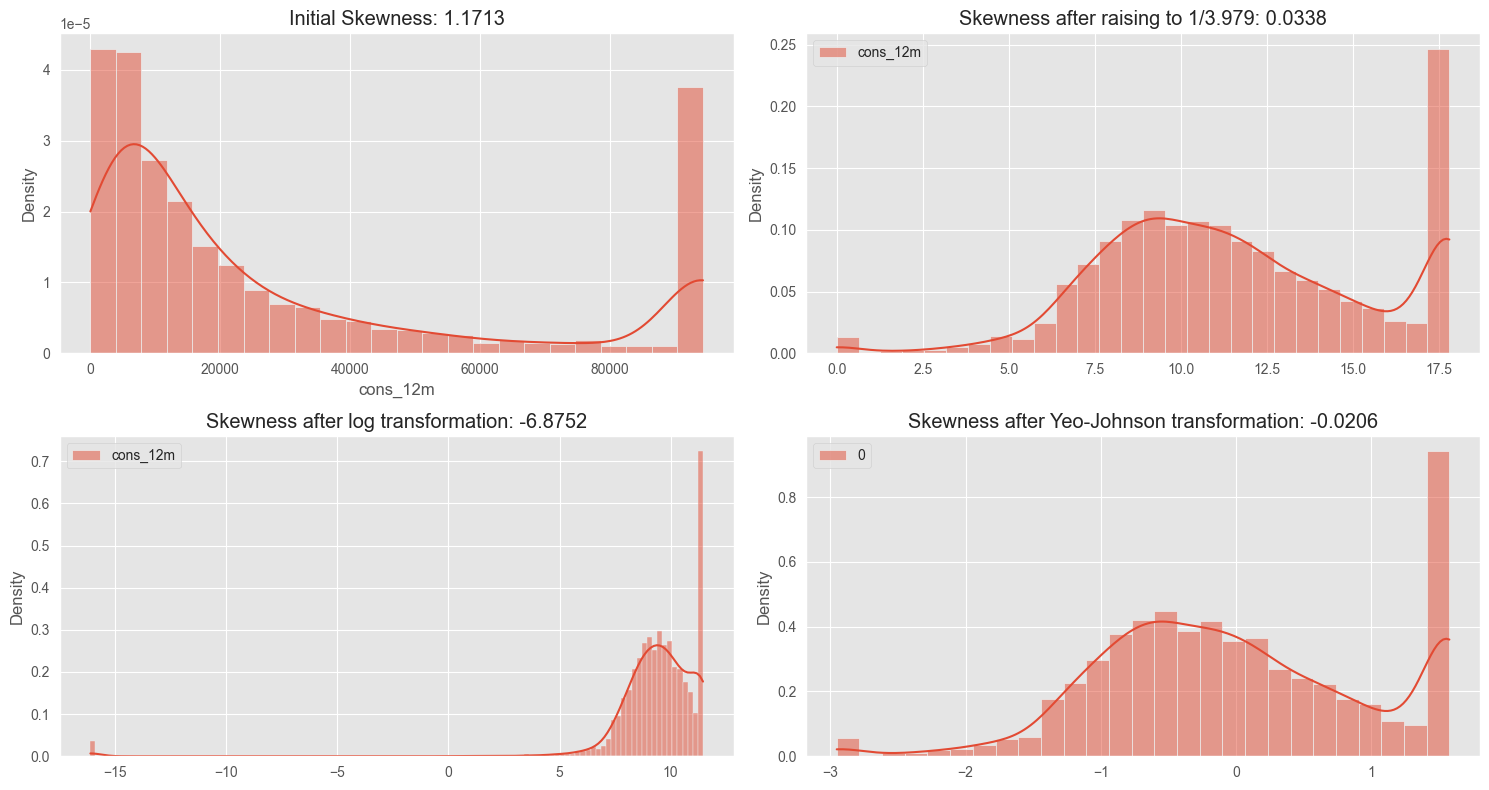

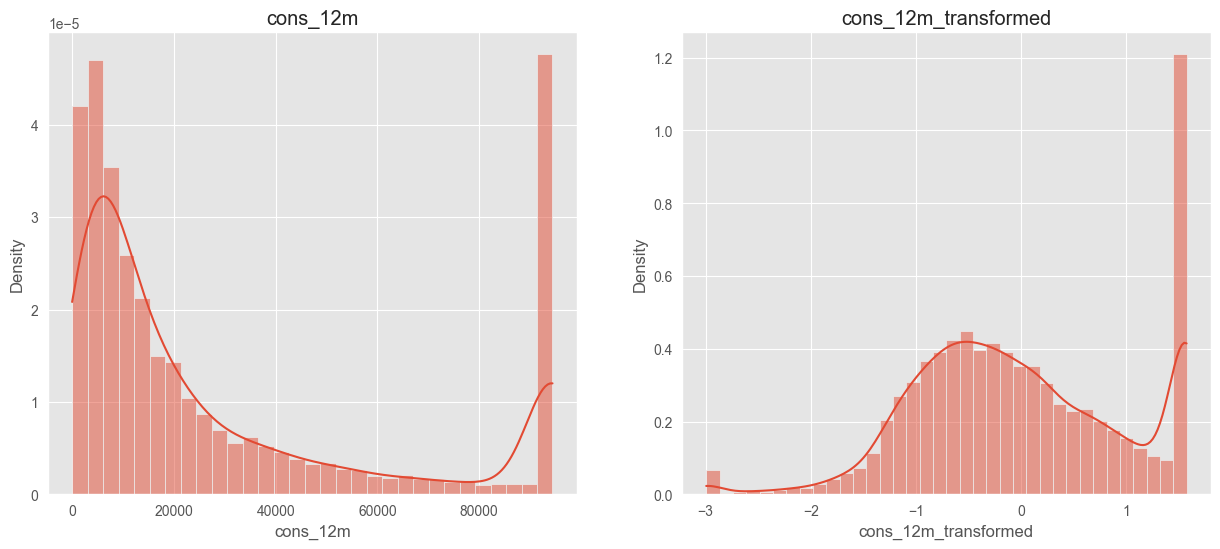

In [33]:
x_train_cleaned , resultados = correct_skew(
                x_train_cleaned,
                'cons_12m',
            plot_all_transformations=True,
            plot_transformed_feature=True,
            verbose=True,
)

In [35]:
resultados

{'0.2513': np.float64(0.0338),
 'log': -6.875247212313147,
 'yeo': -0.02061988763443861}